In [31]:
# GENERAL PACKAGE IMPORT
# ----------------------
import sys
sys.path.append('/Users/huangwp/Documents/git/HIL-Sim/flexlab/db_layer') 
from db_interface import DB_Interface
import requests
import numpy as np
import json
import pandas as pd
from pandas import DataFrame
from io import StringIO

import datetime as dt
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from matplotlib.dates import date2num
import seaborn
import timeit
import json
import pickle

import matplotlib.pyplot as plt
#import oa_temp as oa
#import sa_temp as sa
import datetime
import db_plotting

In [32]:
data20 = pd.read_csv('data20_revised.csv', index_col = 0, parse_dates = True)
data21 = pd.read_csv('data21_revised.csv', index_col = 0, parse_dates = True)

In [33]:
data20['datetime'] = pd.to_datetime(data20['datetime'])
data21['datetime'] = pd.to_datetime(data21['datetime'])

In [34]:
print(type(data21['datetime'].iloc[0]))
print(type(datetime.time(14,0,0)))

data20['date'] = data20['datetime'].apply(lambda x: datetime.date(x.year, x.month, x.day))
data20['time'] = data20['datetime'].apply(lambda x: datetime.time(x.hour, x.minute, x.second))

data21['date'] = data21['datetime'].apply(lambda x: datetime.date(x.year, x.month, x.day))
data21['time'] = data21['datetime'].apply(lambda x: datetime.time(x.hour, x.minute, x.second))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'datetime.time'>


In [35]:
print(data20.columns)

Index(['desk1_plug_power', 'desk2_plug_power', 'desk3_plug_power',
       'desk4_plug_power', 'desk5_plug_power', 'desk6_plug_power',
       'desk3_light_power', 'desk4_light_power', 'desk2_light_power',
       'desk1_6_light_power', 'desk5_light_power', '1A-VAV1-Zn_Temp',
       '1A-VAV2-Zn_Temp', '1A-VAV3-Zn_Temp', '1A-VAV1-OccupiedCoolingSetpt',
       '1A-VAV1-UnoccupiedCoolingSetpt', '1A-VAV1-OccupiedHeatingSetpt',
       '1A-VAV1-UnoccupiedHeatingSetpt', '1A-VAV2-OccupiedCoolingSetpt',
       '1A-VAV2-UnoccupiedHeatingSetpt', '1A-VAV2-UnoccupiedCoolingSetpt',
       '1A-VAV2-OccupiedHeatingSetpt', '1A-VAV3-OccupiedCoolingSetpt',
       '1A-VAV3-UnoccupiedHeatingSetpt', '1A-VAV3-UnoccupiedCoolingSetpt',
       '1A-VAV3-OccupiedHeatingSetpt', '1A-El-AHU', '1A-El-CHWP', '1A-El-HWP',
       '1A-El-Exhaust Fan', '1A-Th-Chilled Water', '1B-OAT-1',
       '1A-MidZone-TCS6-DBT', '1A-NorthZone-DBT', '1A-WindowZone-TCS7-DBT',
       '1A-VAV1-DischargeAirTemp', '1A-VAV2-DischargeAirTemp',
 

### Metrics

In [36]:
data20 = data20.assign(COP='COP') 
#data20['COP'] = data20['oat_C'].apply(lambda x: (0.548 + 0.0951*x + (-7.63E-04)*x**2))
data20['COP'] = 2.9
data21 = data21.assign(COP='COP') 
#data21['COP'] = data21['oat_C'].apply(lambda x: (0.548 + 0.0951*x + (-7.63E-04)*x**2))
data21['COP'] = 2.9

In [37]:
data20 = data20.assign(chiller = 'Chiller_load') 
data20['Chiller_load'] = (data20['1A-Th-Chilled Water']/data20['COP']) *-1
data20['cooling_power [W]'] = data20['1A-El-AHU'] + data20['1A-El-Exhaust Fan'] + data20['1A-El-CHWP'] + data20['Chiller_load']

data21 = data21.assign(chiller = 'Chiller_load') 
data21['Chiller_load'] = (data21['1B-Th-Chilled Water']/data21['COP']) *-1
data21['cooling_power [W]'] = data21['1B-El-AHU'] + data21['1B-El-Exhaust Fan'] + data21['1B-El-CHWP'] + data21['Chiller_load']

# Avg Demand during shed vs Avg OAT 

In [38]:
precool_st = datetime.time(10,0,0)
precool_en = datetime.time(14,0,0)

gta_st = datetime.time(14,0,0)
gta_en = datetime.time(18,0,0)

In [39]:
gta_ts = (data20['time'] >= gta_st) & (data20['time'] <= gta_en)
precool_ts = (data20['time'] >= precool_st) & (data20['time'] <= precool_en)


In [40]:
en_1a = []
en_1b = []
shed_1a=[]
shed_oat=[]
shift_1a=[]
shift_oat=[]

# define dates for the calculation
for day in range(15, 16):    
    mask_1 = data21['date'] == datetime.date(2021, 8, day)
    print(day)
    day_en_1a = round((data20['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1a.append(day_en_1a)
      
    day_en_1b = round((data21['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1b.append(day_en_1b)
    
    day_shed_1a = (data20['cooling_power [W]'][mask_1][gta_ts].mean())   # only select 2-6pm
    shed_1a.append(day_shed_1a)
    
    shed_oat_mean=(data20['1B-OAT-1'][mask_1][gta_ts].mean())  # outdoor air temperature average from 2-6pm
    shed_oat.append(shed_oat_mean) # make daily average temp a list
    
    day_shift_1a = (data20['cooling_power [W]'][mask_1][precool_ts].mean())   # only select 10-2pm
    shift_1a.append(day_shift_1a)
    
    shift_oat_mean=(data20['1B-OAT-1'][mask_1][precool_ts].mean())  # outdoor air temperature average from 10-2pm
    shift_oat.append(shift_oat_mean) # make daily average temp a list
    
       
    
for day in range(20, 22):    
    mask_1 = data21['date'] == datetime.date(2021, 8, day)
    print(day)
    day_en_1a = round((data20['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1a.append(day_en_1a)
      
    day_en_1b = round((data21['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1b.append(day_en_1b)
    
    day_shed_1a = (data20['cooling_power [W]'][mask_1][gta_ts].mean())   # only select 2-6pm
    shed_1a.append(day_shed_1a)
    
    shed_oat_mean=(data20['1B-OAT-1'][mask_1][gta_ts].mean())  # outdoor air temperature average from 2-6pm
    shed_oat.append(shed_oat_mean) # make daily average temp a list
    
    day_shift_1a = (data20['cooling_power [W]'][mask_1][precool_ts].mean())   # only select 10-2pm
    shift_1a.append(day_shift_1a)
    
    shift_oat_mean=(data20['1B-OAT-1'][mask_1][precool_ts].mean())  # outdoor air temperature average from 10-2pm
    shift_oat.append(shift_oat_mean) # make daily average temp a list
    
for day in range(26, 27):    
    mask_1 = data21['date'] == datetime.date(2021, 8, day)
    print(day)
    day_en_1a = round((data20['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1a.append(day_en_1a)
      
    day_en_1b = round((data21['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1b.append(day_en_1b)
    
    day_shed_1a = (data20['cooling_power [W]'][mask_1][gta_ts].mean())   # only select 2-6pm
    shed_1a.append(day_shed_1a)
    
    shed_oat_mean=(data20['1B-OAT-1'][mask_1][gta_ts].mean())  # outdoor air temperature average from 2-6pm
    shed_oat.append(shed_oat_mean) # make daily average temp a list
    
    day_shift_1a = (data20['cooling_power [W]'][mask_1][precool_ts].mean())   # only select 10-2pm
    shift_1a.append(day_shift_1a)
    
    shift_oat_mean=(data20['1B-OAT-1'][mask_1][precool_ts].mean())  # outdoor air temperature average from 10-2pm
    shift_oat.append(shift_oat_mean) # make daily average temp a list
    
for day in range(4, 6):    
    mask_1 = data21['date'] == datetime.date(2021, 9, day)
    print(day)
    day_en_1a = round((data20['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1a.append(day_en_1a)
      
    day_en_1b = round((data21['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1b.append(day_en_1b)
    
    day_shed_1a = (data20['cooling_power [W]'][mask_1][gta_ts].mean())   # only select 2-6pm
    shed_1a.append(day_shed_1a)
    
    shed_oat_mean=(data20['1B-OAT-1'][mask_1][gta_ts].mean())  # outdoor air temperature average from 2-6pm
    shed_oat.append(shed_oat_mean) # make daily average temp a list
    
    day_shift_1a = (data20['cooling_power [W]'][mask_1][precool_ts].mean())   # only select 10-2pm
    shift_1a.append(day_shift_1a)
    
    shift_oat_mean=(data20['1B-OAT-1'][mask_1][precool_ts].mean())  # outdoor air temperature average from 10-2pm
    shift_oat.append(shift_oat_mean) # make daily average temp a list
    
    


15
20
21
26
4
5


In [41]:
shed_1a = np.array(shed_1a)
print(shed_1a)

[1089.68109603  823.71480814  702.6116114   926.89994826 1284.04873765
 1309.89087731]


In [42]:
shed_oat = np.array(shed_oat)
print(shed_oat)

[21.55108235 16.21273529 15.57357059 23.68724118 22.65625294 24.9185    ]


In [43]:
shed_oat=shed_oat*1.8+32. # convert shed_out to Fehrenheit

In [44]:
print(shed_oat)

[70.79194824 61.18292353 60.03242706 74.63703412 72.78125529 76.8533    ]


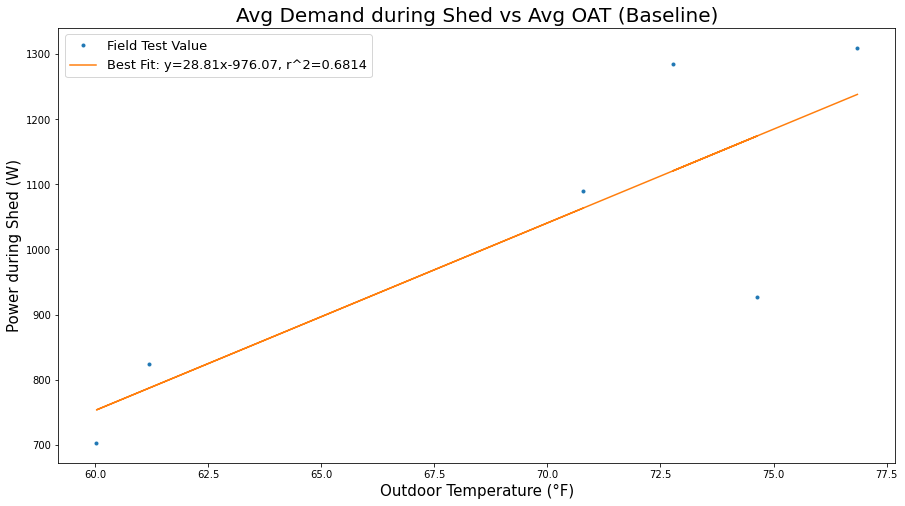

In [45]:
fig,ax=plt.subplots()


res = stats.linregress(shed_oat, shed_1a)
m=res.slope
b=res.intercept
r_squared=res.rvalue**2




plt.plot(shed_oat,shed_1a,".", label="Field Test Value")
equation="Best Fit: y="+str(round(m,2))+"x"+str(round(b,2))+", r^2="+str(round(r_squared,4))
plt.plot(shed_oat, m*shed_oat + b, label=equation)



plt.title('Avg Demand during Shed vs Avg OAT (Baseline)',fontsize=20)
plt.xlabel('Outdoor Temperature (°F)',fontsize=15)
plt.ylabel('Power during Shed (W)',fontsize=15)
fig.set_size_inches(15, 8)





plt.legend(loc=2,fontsize=13)
plt.show()





In [46]:
shift_1a = np.array(shift_1a)
print(shift_1a)

[ 926.90435298  902.23526407  718.4312798   935.15753485 1082.21404542
 1177.2822548 ]


In [47]:
shift_oat = np.array(shift_oat)
print(shift_oat)

[21.32005882 17.1559     15.06088235 21.65605294 19.03764706 22.60790588]


In [48]:
shift_oat=shift_oat*1.8+32. # convert shed_out to Fehrenheit
print(shift_oat)

[70.37610588 62.88062    59.10958824 70.98089529 66.26776471 72.69423059]


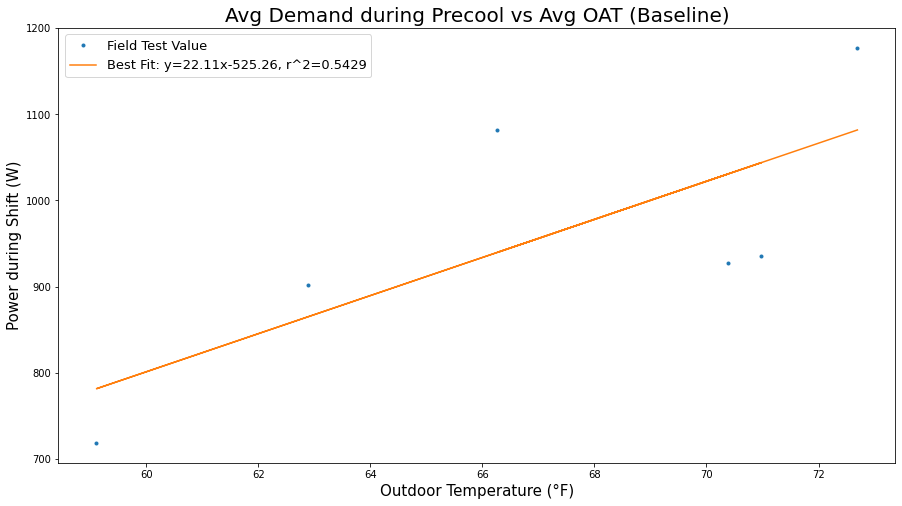

In [49]:
fig,ax=plt.subplots()


res2 = stats.linregress(shift_oat, shift_1a)
m2=res2.slope
b2=res2.intercept
r_squared2=res2.rvalue**2




plt.plot(shift_oat,shift_1a,".", label="Field Test Value")
equation="Best Fit: y="+str(round(m2,2))+"x"+str(round(b2,2))+", r^2="+str(round(r_squared2,4))
plt.plot(shift_oat, m2*shift_oat + b2, label=equation)



plt.title('Avg Demand during Precool vs Avg OAT (Baseline)',fontsize=20)
plt.xlabel('Outdoor Temperature (°F)',fontsize=15)
plt.ylabel('Power during Shift (W)',fontsize=15)
fig.set_size_inches(15, 8)





plt.legend(loc=2,fontsize=13)
plt.show()




# Shed: demand vs AVG OAT (shed period)

In [50]:
en_1a = []
en_1b = []
shed_1a=[]
shed_oat=[]



# define dates for the calculation
for day in range(22, 24):    
    mask_1 = data21['date'] == datetime.date(2021, 8, day)
    print(day)
    day_en_1a = round((data20['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1a.append(day_en_1a)
      
    day_en_1b = round((data21['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1b.append(day_en_1b)
    
    day_shed_1a = (data20['cooling_power [W]'][mask_1][gta_ts].mean())   # only select 2-6pm
    shed_1a.append(day_shed_1a)
    
    shed_oat_mean=(data20['1B-OAT-1'][mask_1][gta_ts].mean())  # outdoor air temperature average from 2-6pm
    shed_oat.append(shed_oat_mean) # make daily average temp a list
    

    
for day in range(1, 2):    
    mask_1 = data21['date'] == datetime.date(2021, 9, day)
    print(day)
    day_en_1a = round((data20['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1a.append(day_en_1a)
      
    day_en_1b = round((data21['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1b.append(day_en_1b)
    
    day_shed_1a = (data20['cooling_power [W]'][mask_1][gta_ts].mean())   # only select 2-6pm
    shed_1a.append(day_shed_1a)
    
    shed_oat_mean=(data20['1B-OAT-1'][mask_1][gta_ts].mean())  # outdoor air temperature average from 2-6pm
    shed_oat.append(shed_oat_mean) # make daily average temp a list
    


22
23
1


[841.62544125 753.04854084 764.23284001]
[19.47745294 16.73550588 17.94892941]
[67.05941529 62.12391059 64.30807294]


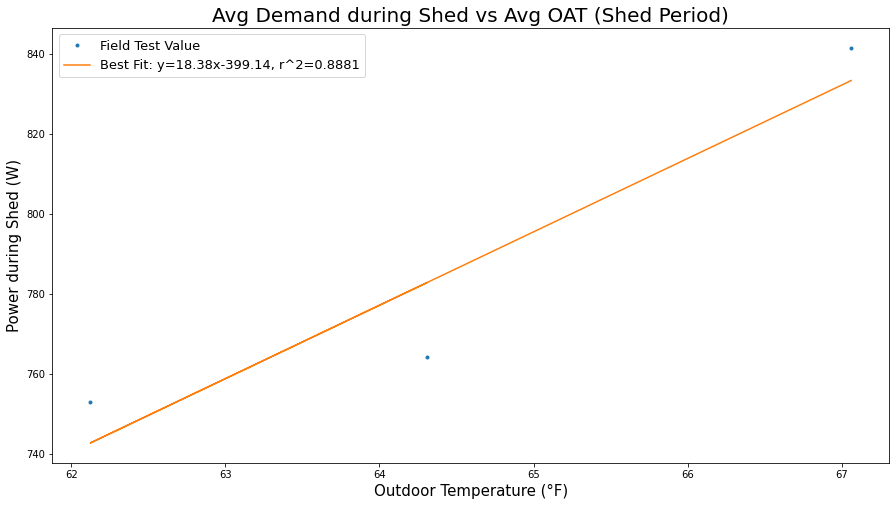

In [51]:
shed_1a = np.array(shed_1a)
print(shed_1a)

shed_oat = np.array(shed_oat)
print(shed_oat)

shed_oat=shed_oat*1.8+32. # convert shed_out to Fehrenheit

print(shed_oat)

fig,ax=plt.subplots()

res = stats.linregress(shed_oat, shed_1a)
m=res.slope
b=res.intercept
r_squared=res.rvalue**2



plt.plot(shed_oat,shed_1a,".", label="Field Test Value")
equation="Best Fit: y="+str(round(m,2))+"x"+str(round(b,2))+", r^2="+str(round(r_squared,4))
plt.plot(shed_oat, m*shed_oat + b, label=equation)



plt.title('Avg Demand during Shed vs Avg OAT (Shed Period)',fontsize=20)
plt.xlabel('Outdoor Temperature (°F)',fontsize=15)
plt.ylabel('Power during Shed (W)',fontsize=15)
fig.set_size_inches(15, 8)





plt.legend(loc=2,fontsize=13)
plt.show()


# Shift: demand vs AVG OAT (shed and shift periods)


In [52]:
en_1a = []
en_1b = []
shed_1a=[]
shed_oat=[]
shift_1a=[]
shift_oat=[]

# define dates for the calculation
for day in range(28, 30):    
    mask_1 = data21['date'] == datetime.date(2021, 8, day)
    print(day)
    day_en_1a = round((data20['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1a.append(day_en_1a)
      
    day_en_1b = round((data21['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1b.append(day_en_1b)
    
    day_shed_1a = (data20['cooling_power [W]'][mask_1][gta_ts].mean())   # only select 2-6pm
    shed_1a.append(day_shed_1a)
    
    shed_oat_mean=(data20['1B-OAT-1'][mask_1][gta_ts].mean())  # outdoor air temperature average from 2-6pm
    shed_oat.append(shed_oat_mean) # make daily average temp a list
    
    day_shift_1a = (data20['cooling_power [W]'][mask_1][precool_ts].mean())   # only select 10-2pm
    shift_1a.append(day_shift_1a)
    
    shift_oat_mean=(data20['1B-OAT-1'][mask_1][precool_ts].mean())  # outdoor air temperature average from 10-2pm
    shift_oat.append(shift_oat_mean) # make daily average temp a list
    
for day in range(6, 8):    
    mask_1 = data21['date'] == datetime.date(2021, 9, day)
    print(day)
    day_en_1a = round((data20['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1a.append(day_en_1a)
      
    day_en_1b = round((data21['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1b.append(day_en_1b)
    
    day_shed_1a = (data20['cooling_power [W]'][mask_1][gta_ts].mean())   # only select 2-6pm
    shed_1a.append(day_shed_1a)
    
    shed_oat_mean=(data20['1B-OAT-1'][mask_1][gta_ts].mean())  # outdoor air temperature average from 2-6pm
    shed_oat.append(shed_oat_mean) # make daily average temp a list
    
    day_shift_1a = (data20['cooling_power [W]'][mask_1][precool_ts].mean())   # only select 10-2pm
    shift_1a.append(day_shift_1a)
    
    shift_oat_mean=(data20['1B-OAT-1'][mask_1][precool_ts].mean())  # outdoor air temperature average from 10-2pm
    shift_oat.append(shift_oat_mean) # make daily average temp a list

28
29
6
7


[1156.9077794  1043.16616081 1125.73086014 1055.76363525]
[28.16618824 22.76262353 27.22407647 22.53763529]
[82.69913882 72.97272235 81.00333765 72.56774353]


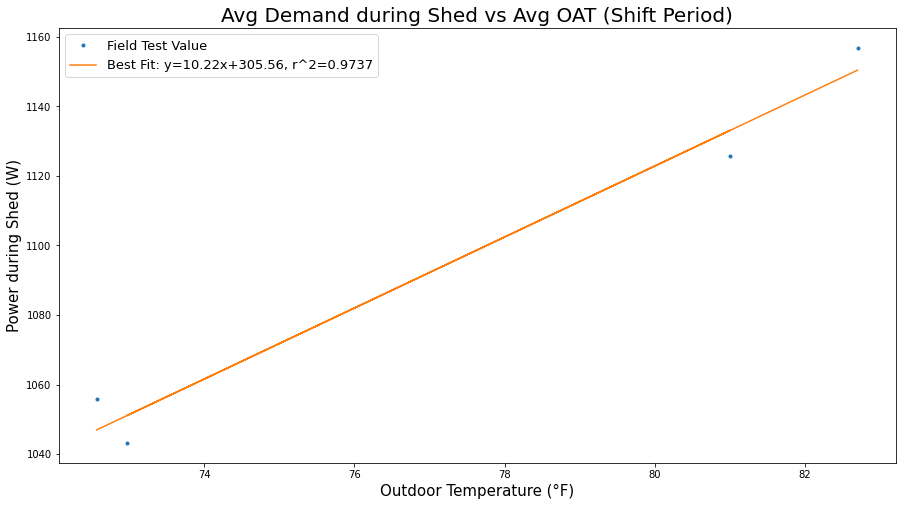

In [53]:
shed_1a = np.array(shed_1a)
print(shed_1a)

shed_oat = np.array(shed_oat)
print(shed_oat)

shed_oat=shed_oat*1.8+32# convert shed_out to Fehrenheit

print(shed_oat)

fig,ax=plt.subplots()

res = stats.linregress(shed_oat, shed_1a)
m=res.slope
b=res.intercept
r_squared=res.rvalue**2



plt.plot(shed_oat,shed_1a,".", label="Field Test Value")
equation="Best Fit: y="+str(round(m,2))+"x+"+str(round(b,2))+", r^2="+str(round(r_squared,4))
plt.plot(shed_oat, m*shed_oat + b, label=equation)



plt.title('Avg Demand during Shed vs Avg OAT (Shift Period)',fontsize=20)
plt.xlabel('Outdoor Temperature (°F)',fontsize=15)
plt.ylabel('Power during Shed (W)',fontsize=15)
fig.set_size_inches(15, 8)





plt.legend(loc=2,fontsize=13)
plt.show()


[1433.69021409 1408.91824902 1321.22639926 1330.47654437]
[28.86018824 21.76449412 25.0763     21.0391    ]
[83.94833882 71.17608941 77.13734    69.87038   ]


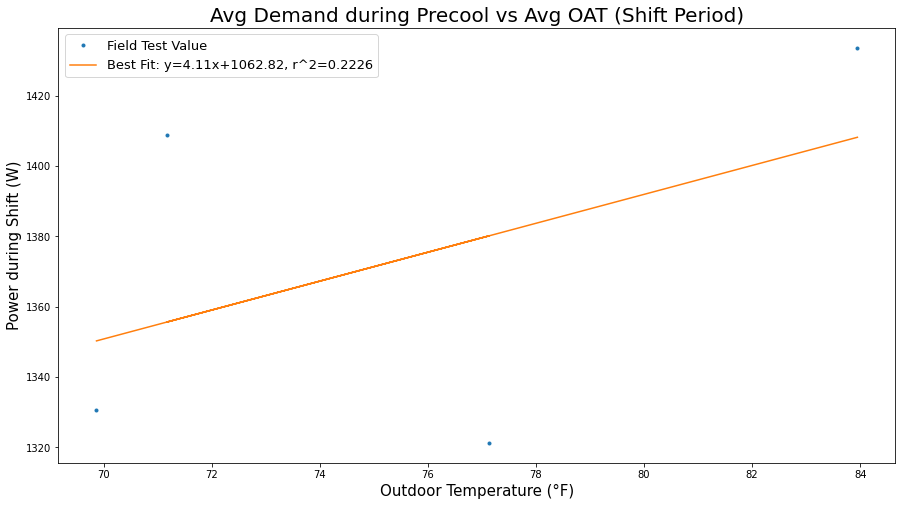

In [54]:
shift_1a = np.array(shift_1a)
print(shift_1a)

shift_oat = np.array(shift_oat)
print(shift_oat)

shift_oat=shift_oat*1.8+32. # convert shed_out to Fehrenheit
print(shift_oat)



fig,ax=plt.subplots()


res2 = stats.linregress(shift_oat, shift_1a)
m2=res2.slope
b2=res2.intercept
r_squared2=res2.rvalue**2




plt.plot(shift_oat,shift_1a,".", label="Field Test Value")
equation="Best Fit: y="+str(round(m2,2))+"x+"+str(round(b2,2))+", r^2="+str(round(r_squared2,4))
plt.plot(shift_oat, m2*shift_oat + b2, label=equation)



plt.title('Avg Demand during Precool vs Avg OAT (Shift Period)',fontsize=20)
plt.xlabel('Outdoor Temperature (°F)',fontsize=15)
plt.ylabel('Power during Shift (W)',fontsize=15)
fig.set_size_inches(15, 8)





plt.legend(loc=2,fontsize=13)
plt.show()

In [55]:
en_1a = []
en_1b = []
shed_1a=[]
shed_oat=[]
shift_1a=[]
shift_oat=[]

# define dates for the calculation
for day in range(15, 32):    
    mask_1 = data21['date'] == datetime.date(2021, 8, day)
    print(day)
    
    
    shed_oat_mean=(data20['1B-OAT-1'][mask_1][gta_ts].mean())  # outdoor air temperature average from 2-6pm
    shed_oat_mean=shed_oat_mean*1.8+32
    shed_oat_mean=round(shed_oat_mean,3)
    shed_oat.append(shed_oat_mean) # make daily average temp a list
    

    
    shift_oat_mean=(data20['1B-OAT-1'][mask_1][precool_ts].mean())  # outdoor air temperature average from 10-2pm
    shift_oat_mean=shift_oat_mean*1.8+32
    shift_oat_mean=round(shift_oat_mean,3)
    shift_oat.append(shift_oat_mean) # make daily average temp a list
    
for day in range(1, 14):    
    mask_1 = data21['date'] == datetime.date(2021, 9, day)
    print(day)

    
    shed_oat_mean=(data20['1B-OAT-1'][mask_1][gta_ts].mean())  # outdoor air temperature average from 2-6pm
    shed_oat_mean=shed_oat_mean*1.8+32
    shed_oat_mean=round(shed_oat_mean,3)
    shed_oat.append(shed_oat_mean) # make daily average temp a list
    
    
    shift_oat_mean=(data20['1B-OAT-1'][mask_1][precool_ts].mean())  # outdoor air temperature average from 10-2pm
    shift_oat_mean=shift_oat_mean*1.8+32
    shift_oat_mean=round(shift_oat_mean,3)
    shift_oat.append(shift_oat_mean) # make daily average temp a list
    
shed_oat = np.array(shed_oat)



print(shed_oat)

shift_oat = np.array(shift_oat)

print(shift_oat)


15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
[70.792 77.677 70.374 66.604 67.244 61.183 60.032 67.059 62.124 65.258
 66.776 74.637    nan 82.699 72.973 70.527 67.014 64.308 65.168 64.688
 72.781 76.853 81.003 72.568 75.35  69.471 65.877 68.135 73.577 72.023]
[70.376 72.024 65.975 67.183 67.249 62.881 59.11  63.47  61.859 62.978
 62.209 70.981 79.142 83.948 71.176 67.383 65.886 63.015 62.852 62.732
 66.268 72.694 77.137 69.87  75.979 69.072 64.669 67.701 70.277 69.099]


In [56]:
for x in shed_oat:
    print(x) 

70.792
77.677
70.374
66.604
67.244
61.183
60.032
67.059
62.124
65.258
66.776
74.637
nan
82.699
72.973
70.527
67.014
64.308
65.168
64.688
72.781
76.853
81.003
72.568
75.35
69.471
65.877
68.135
73.577
72.023


In [57]:
for x in shift_oat:
    print(x) 

70.376
72.024
65.975
67.183
67.249
62.881
59.11
63.47
61.859
62.978
62.209
70.981
79.142
83.948
71.176
67.383
65.886
63.015
62.852
62.732
66.268
72.694
77.137
69.87
75.979
69.072
64.669
67.701
70.277
69.099


In [58]:

shed_oat.item(2)

70.374

In [59]:
shed_oat.size

30

In [60]:
for x in shed_oat:
    print(x) 

70.792
77.677
70.374
66.604
67.244
61.183
60.032
67.059
62.124
65.258
66.776
74.637
nan
82.699
72.973
70.527
67.014
64.308
65.168
64.688
72.781
76.853
81.003
72.568
75.35
69.471
65.877
68.135
73.577
72.023
